In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from pathlib import Path

sns.set(rc={"figure.figsize":(16, 5)})
pd.options.display.max_rows = None
pd.options.display.max_colwidth = None

path = Path().parent.absolute()
bike_path = path / "data" / "Fahrraddiebstahl.csv"
lor_ort_path = path / "data" / "lor_ortsteile.csv"
lor_bzr_path = path / "data" / "lor_bezirksregionen_2021.csv"


In [2]:
bike_dtypes = {
    "ANGELEGT_AM": "object",
    "TATZEIT_ANFANG_DATUM": "object",
    "TATZEIT_ANFANG_STUNDE": "int64",
    "TATZEIT_ENDE_DATUM": "object",
    "TATZEIT_ENDE_STUNDE": "int64",
    "LOR": "object",
    "SCHADENSHOEHE": "int64",
    "VERSUCH": "object",
    "ART_DES_FAHRRADS": "object",
    "DELIKT": "object",
    "ERFASSUNGSGRUND": "object",
}

lor_ort_dtypes = {
    "spatial_name": "object",
    "OTEIL": "object",
    "BEZIRK": "object",
    "FLAECHE_HA": "float64",
}

lor_bzr_dtypes = {
    "BZR_ID": "object",
    "BZR_NAME": "object",
    "BEZ": "object",
    "GROESSE_m2": "float64",
}


In [3]:
with open(bike_path, "rb") as file:
    bike_data = pd.read_csv(file, encoding="latin1", dtype=bike_dtypes)

with open(lor_ort_path, "rb") as file:
    lor_ort_data = pd.read_csv(
        file,
        encoding="utf-8",
        dtype=lor_ort_dtypes,
        usecols=["spatial_name", "BEZIRK"],
    )

with open(lor_bzr_path, "rb") as file:
    lor_bzr_data = pd.read_csv(
        file,
        encoding="utf-8",
        dtype=lor_bzr_dtypes,
        usecols=["BZR_ID", "BZR_NAME", "BEZ", "GROESSE_m2"],
    )

In [4]:
# Aufbereitung von timevalues
bike_data["ANGELEGT_AM"] = pd.to_datetime(bike_data["ANGELEGT_AM"], dayfirst=True)
bike_data["TATZEIT_ANFANG_DATUM"] = pd.to_datetime(
    bike_data["TATZEIT_ANFANG_DATUM"], dayfirst=True
) + pd.to_timedelta(bike_data.TATZEIT_ANFANG_STUNDE, unit="h")
bike_data["TATZEIT_ENDE_DATUM"] = pd.to_datetime(
    bike_data["TATZEIT_ENDE_DATUM"], dayfirst=True
) + pd.to_timedelta(bike_data.TATZEIT_ENDE_STUNDE, unit="h")
bike_data["TATDAUER_STUNDEN"] = (
    bike_data.TATZEIT_ENDE_DATUM - bike_data.TATZEIT_ANFANG_DATUM
).astype("timedelta64[h]")

# Vorbereitung eines keys zum Join mit Bezirksübersichtstabelle
bike_data["BZR_ID"] = bike_data["LOR"].str[0:6]
lor_ort_data["spatial_name"] = lor_ort_data["spatial_name"].str[0:2]
lor_ort_data = lor_ort_data.rename(columns={"spatial_name": "BEZ"})


In [5]:
# bike_data.info()
# lor_ort_data.info()
# lor_bez_data.info()


In [6]:
# bike_data.head()

In [7]:
merged_df = bike_data.merge(lor_bzr_data, how="left", on="BZR_ID")
merged_df = merged_df.merge(lor_ort_data, how="left", on="BEZ")
del lor_ort_data, lor_ort_dtypes, lor_ort_path, lor_bzr_data, lor_bzr_dtypes, lor_bzr_path

merged_df.head()

,ANGELEGT_AM,TATZEIT_ANFANG_DATUM,TATZEIT_ANFANG_STUNDE,TATZEIT_ENDE_DATUM,TATZEIT_ENDE_STUNDE,LOR,SCHADENSHOEHE,VERSUCH,ART_DES_FAHRRADS,DELIKT,ERFASSUNGSGRUND,TATDAUER_STUNDEN,BZR_ID,BZR_NAME,BEZ,GROESSE_m2,BEZIRK
0,2023-02-19,2023-02-18 18:00:00,18,2023-02-19 07:00:00,7,03701658,3472,Nein,Herrenfahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,13.0,037016,Prenzlauer Berg Süd,03,1660928.148,Pankow
1,2023-02-19,2023-02-18 18:00:00,18,2023-02-19 07:00:00,7,03701658,3472,Nein,Herrenfahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,13.0,037016,Prenzlauer Berg Süd,03,1660928.148,Pankow
2,2023-02-19,2023-02-18 18:00:00,18,2023-02-19 07:00:00,7,03701658,3472,Nein,Herrenfahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,13.0,037016,Prenzlauer Berg Süd,03,1660928.148,Pankow
3,2023-02-19,2023-02-18 18:00:00,18,2023-02-19 07:00:00,7,03701658,3472,Nein,Herrenfahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,13.0,037016,Prenzlauer Berg Süd,03,1660928.148,Pankow
4,2023-02-19,2023-02-18 18:00:00,18,2023-02-19 07:00:00,7,03701658,3472,Nein,Herrenfahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,13.0,037016,Prenzlauer Berg Süd,03,1660928.148,Pankow


In [8]:
# Übersicht über unique values der einzelnen Spalten

# merged_df.columns.to_list()
# for col in merged_df[
#     [
#         "VERSUCH",
#         "ART_DES_FAHRRADS",
#         "DELIKT",
#         "ERFASSUNGSGRUND",
#         "BEZIRK",
#     ]
# ]:
#     print(f"{col} : \n {merged_df[col].unique()}")


## Auswertung

Annahmen:
- Günstige Fahrräder (<= 200€) sind seltener versichert und Diebstähle führen daher seltener zu polizeilicher Erfassung <br> --> Dunkelziffer günstiger geklauter Fahrräder nicht abschätzbar im Rahmen dieser Aufgabe


### Fragen

- Was sind die Absolutwerte der Delikte?
    - Fahrraddiebstähle in den Zehntausendern   
- Was sind die Minima/Maxima der Zeiträume?
    - Daten zwischen 01.01.2022 und 19.02.2023

In [9]:
merged_df.groupby(["BEZIRK"], dropna=False).agg(
    {
        "ANGELEGT_AM": ["count", "min", "max"],
        "TATZEIT_ANFANG_DATUM": ["min", "max"],
        "TATZEIT_ENDE_DATUM": ["min", "max"],
    }
).sort_values(by=("ANGELEGT_AM", "count"), ascending=False)

ANGELEGT_AM                        \
                                 count        min        max   
BEZIRK                                                         
Pankow                           44811 2022-01-01 2023-02-19   
Treptow-Köpenick                 25695 2022-01-02 2023-02-19   
Mitte                            23778 2022-01-01 2023-02-19   
Charlottenburg-Wilmersdorf       17234 2022-01-02 2023-02-19   
Lichtenberg                      13930 2022-01-03 2023-02-19   
Tempelhof-Schöneberg             13170 2022-01-02 2023-02-19   
Steglitz-Zehlendorf              10535 2022-01-03 2023-02-19   
Reinickendorf                     9768 2022-01-03 2023-02-19   
Neukölln                          9410 2022-01-03 2023-02-19   
Friedrichshain-Kreuzberg          7262 2022-01-01 2023-02-19   
Spandau                           6543 2022-01-07 2023-02-19   
Marzahn-Hellersdorf               4020 2022-01-04 2023-02-18   

                           TATZEIT_ANFANG_DATUM                      \
                                            min                 max   
BEZIRK                                                                
Pankow                      2022-01-01 02:00:00 2023-02-19 11:00:00   
Treptow-Köpenick            2022-01-01 08:00:00 2023-02-18 23:00:00   
Mitte                       2022-01-01 00:00:00 2023-02-19 04:00:00   
Charlottenburg-Wilmersdorf  2022-01-01 13:00:00 2023-02-18 17:00:00   
Lichtenberg                 2022-01-02 11:00:00 2023-02-18 19:00:00   
Tempelhof-Schöneberg        2022-01-01 00:00:00 2023-02-18 17:00:00   
Steglitz-Zehlendorf         2022-01-02 09:00:00 2023-02-18 16:00:00   
Reinickendorf               2022-01-02 17:00:00 2023-02-18 12:00:00   
Neukölln                    2022-01-01 12:00:00 2023-02-17 12:00:00   
Friedrichshain-Kreuzberg    2022-01-01 04:00:00 2023-02-19 18:00:00   
Spandau                     2022-01-05 03:00:00 2023-02-18 23:00:00   
Marzahn-Hellersdorf         2022-01-03 18:00:00 2023-02-15 18:00:00   

                            TATZEIT_ENDE_DATUM                      
                                           min                 max  
BEZIRK                                                              
Pankow                     2022-01-01 14:00:00 2023-02-19 21:00:00  
Treptow-Köpenick           2022-01-01 08:00:00 2023-02-19 16:00:00  
Mitte                      2022-01-01 00:00:00 2023-02-19 09:00:00  
Charlottenburg-Wilmersdorf 2022-01-02 11:00:00 2023-02-19 10:00:00  
Lichtenberg                2022-01-03 07:00:00 2023-02-19 09:00:00  
Tempelhof-Schöneberg       2022-01-02 10:00:00 2023-02-19 00:00:00  
Steglitz-Zehlendorf        2022-01-02 14:00:00 2023-02-19 00:00:00  
Reinickendorf              2022-01-02 20:00:00 2023-02-18 22:00:00  
Neukölln                   2022-01-01 18:00:00 2023-02-18 11:00:00  
Friedrichshain-Kreuzberg   2022-01-01 08:00:00 2023-02-19 19:00:00  
Spandau                    2022-01-05 07:00:00 2023-02-19 01:00:00  
Marzahn-Hellersdorf        2022-01-04 07:00:00 2023-02-18 14:00:00

Was wird am meisten zur Anzeige gebracht?
- Aus der folgenden Tabelle schließe ich, dass ein "Versuch" ein vereitelter Diebstahl ist
- Fahrraddiebstähle werden deutlich häufiger angezeigt als Einbrüche, vermutlich gibt es erstere generell deutlich häufiger

In [10]:
merged_df.groupby("VERSUCH").agg({"SCHADENSHOEHE":["count","sum"]})

SCHADENSHOEHE           
                  count        sum
VERSUCH                           
Ja                  467          0
Nein             185654  194970189
Unbekannt            35      52680

In [11]:
merged_df.groupby(["DELIKT"], dropna=False).agg(
    {"ANGELEGT_AM": "count", "SCHADENSHOEHE":"sum" ,"TATDAUER_STUNDEN": ["mean", "median", "std"]}
).sort_values(by=("ANGELEGT_AM", "count"), ascending=False)


ANGELEGT_AM SCHADENSHOEHE TATDAUER_STUNDEN         \
                                count           sum             mean median   
DELIKT                                                                        
Fahrraddiebstahl               177779     183027468        13.466354    9.0   
Keller- und Bodeneinbruch        8377      11995401        26.121046   21.0   

                                      
                                 std  
DELIKT                                
Fahrraddiebstahl           15.175310  
Keller- und Bodeneinbruch  20.811949

#### Angezeigte Fälle + Schaden pro Bezirk in €
- Marzahn-Hellersdorf hat Vergleichsweise wenig Diebsttähle, dafür aber überproportional viele Kellereinbrüche (Keller/Böden besser sichern?)
- Die mittleren, angezeigten Schadenssummen deuten auf mittel- bis hochwertige Fahrradmodelle hin
- Schadenssummen bei Keller- und Bödeneinbrüchen in der Regel höher als bei einfachen Diebstählen (wird hier Schaden anders berechnet?)
- Mitte scheint die im Schnitt teuersten Räder zu haben

In [12]:
merged_df.pivot_table(
    index="BEZIRK",
    columns="DELIKT",
    aggfunc={"SCHADENSHOEHE": ["count", "median", "mean"]},
).sort_values(by=("SCHADENSHOEHE", "count", "Fahrraddiebstahl"), ascending=False)

SCHADENSHOEHE                            \
                                      count                             
DELIKT                     Fahrraddiebstahl Keller- und Bodeneinbruch   
BEZIRK                                                                  
Pankow                                43329                      1482   
Treptow-Köpenick                      24225                      1470   
Mitte                                 22944                       834   
Charlottenburg-Wilmersdorf            16604                       630   
Lichtenberg                           12840                      1090   
Tempelhof-Schöneberg                  12714                       456   
Steglitz-Zehlendorf                   10248                       287   
Reinickendorf                          9284                       484   
Neukölln                               9200                       210   
Friedrichshain-Kreuzberg               7070                       192   
Spandau                                6066                       477   
Marzahn-Hellersdorf                    3255                       765   

                                                                       \
                                       mean                             
DELIKT                     Fahrraddiebstahl Keller- und Bodeneinbruch   
BEZIRK                                                                  
Pankow                          1008.033003               1346.456140   
Treptow-Köpenick                 968.457585               1512.571429   
Mitte                           1117.627615               1390.683453   
Charlottenburg-Wilmersdorf      1160.153879               1866.288889   
Lichtenberg                     1010.429128               1290.146789   
Tempelhof-Schöneberg            1001.094384               1717.052632   
Steglitz-Zehlendorf              987.782104               1438.317073   
Reinickendorf                    979.485782               1428.863636   
Neukölln                         976.848913               1363.095238   
Friedrichshain-Kreuzberg        1033.906082               1290.239583   
Spandau                         1129.627596               1370.339623   
Marzahn-Hellersdorf              895.935484               1254.444444   

                                                                       
                                     median                            
DELIKT                     Fahrraddiebstahl Keller- und Bodeneinbruch  
BEZIRK                                                                 
Pankow                                729.0                     999.5  
Treptow-Köpenick                      655.0                     933.0  
Mitte                                 850.0                     925.0  
Charlottenburg-Wilmersdorf            849.0                    1200.0  
Lichtenberg                           656.5                     800.0  
Tempelhof-Schöneberg                  700.0                    1250.0  
Steglitz-Zehlendorf                   700.0                    1000.0  
Reinickendorf                         628.5                     950.0  
Neukölln                              700.0                     900.0  
Friedrichshain-Kreuzberg              749.0                    1000.0  
Spandau                               700.0                     900.0  
Marzahn-Hellersdorf                   587.0                     800.0

- Schwerer Fahrraddiebstahl scheint Haupterfassungsgrund
- Schwerer Fahrraddiebstahl = teueres Rad = höherer Schaden?

In [13]:
merged_df.pivot_table(
    index="BEZIRK",
    columns="ERFASSUNGSGRUND",
    aggfunc={"SCHADENSHOEHE": ["count", "median"]},
).sort_values(by=('SCHADENSHOEHE', 'count', 'Sonstiger schwerer Diebstahl von Fahrrädern'), ascending=False)

SCHADENSHOEHE  \
                                                                         count   
ERFASSUNGSGRUND            Einfacher Diebstahl aus Keller/Boden von Fahrrädern   
BEZIRK                                                                           
Pankow                                                                    78.0   
Treptow-Köpenick                                                          45.0   
Mitte                                                                     30.0   
Charlottenburg-Wilmersdorf                                                21.0   
Lichtenberg                                                               30.0   
Tempelhof-Schöneberg                                                      24.0   
Steglitz-Zehlendorf                                                       28.0   
Reinickendorf                                                              NaN   
Neukölln                                                                   NaN   
Friedrichshain-Kreuzberg                                                   6.0   
Spandau                                                                    NaN   
Marzahn-Hellersdorf                                                       45.0   

                                                               \
                                                                
ERFASSUNGSGRUND            Einfacher Diebstahl von Fahrrädern   
BEZIRK                                                          
Pankow                                                 2171.0   
Treptow-Köpenick                                        960.0   
Mitte                                                  1212.0   
Charlottenburg-Wilmersdorf                             1050.0   
Lichtenberg                                             440.0   
Tempelhof-Schöneberg                                    678.0   
Steglitz-Zehlendorf                                     504.0   
Reinickendorf                                           473.0   
Neukölln                                                465.0   
Friedrichshain-Kreuzberg                                398.0   
Spandau                                                 459.0   
Marzahn-Hellersdorf                                      95.0   

                                                                                            \
                                                                                             
ERFASSUNGSGRUND            Sonstiger schwerer Diebstahl in/aus Keller/Boden von Fahrrädern   
BEZIRK                                                                                       
Pankow                                                                              1482.0   
Treptow-Köpenick                                                                    1470.0   
Mitte                                                                                834.0   
Charlottenburg-Wilmersdorf                                                           630.0   
Lichtenberg                                                                         1090.0   
Tempelhof-Schöneberg                                                                 456.0   
Steglitz-Zehlendorf                                                                  287.0   
Reinickendorf                                                                        484.0   
Neukölln                                                                             210.0   
Friedrichshain-Kreuzberg                                                             192.0   
Spandau                                                                              477.0   
Marzahn-Hellersdorf                                                                  765.0   

                                                                        \
                                                                         
ERFASSUNGSGRUND            Sonstiger schwerer Diebstahl vo

### In welchem Wertbereich wird am meisten geklaut und folgend angezeigt?
- Graph zeigt, das Fahrräder im mittleren Preissegment (ca. 300€ - 750€) in beiden Delikts-Arten am häufigsten als geklaut angezeigt werden


<Axes: xlabel='SCHADENSHOEHE', ylabel='Count'>

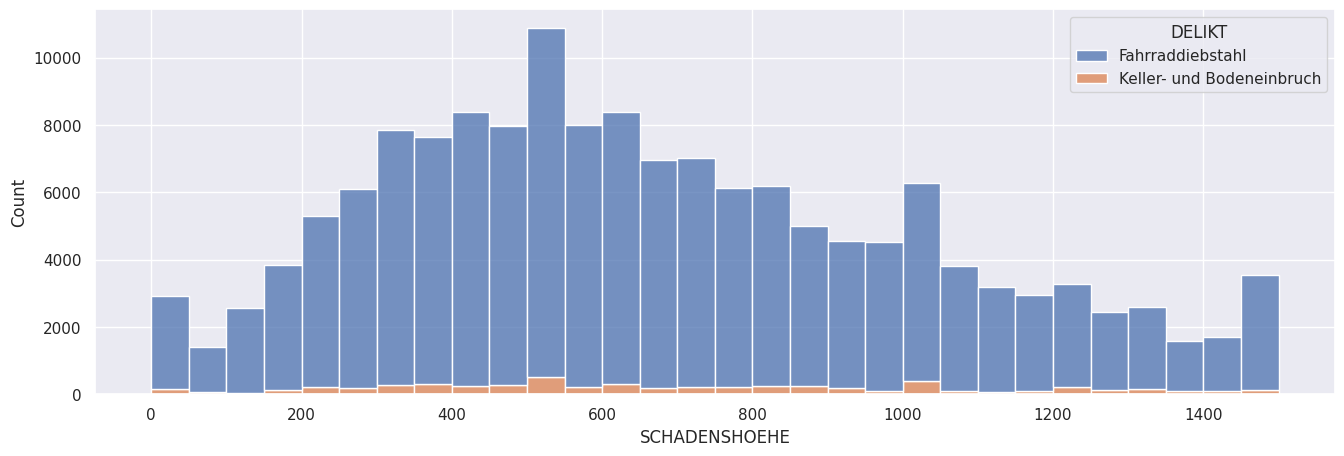

In [14]:
sns.histplot(
    data=merged_df,
    x="SCHADENSHOEHE",
    binrange=[0, 1500],
    binwidth=50,
    hue="DELIKT",
    multiple="stack",
)

### Wie lange dauert ein Tatvorgang im Allgemeinen?
- Der nachfolgende Graph deutet auf schnelle Diebstähle von unter einer Stunde hin 

ANMERKUNG: Es ist möglich, dass ein Diebstahl, eine willkürliche Dauer zugeschrieben bekommen hat, wenn die Tatdauer nicht bekannt ist. Möglicherweise wurde in diesem Fall 0 Stunden als Default gewählt.

<Axes: xlabel='TATDAUER_STUNDEN', ylabel='Count'>

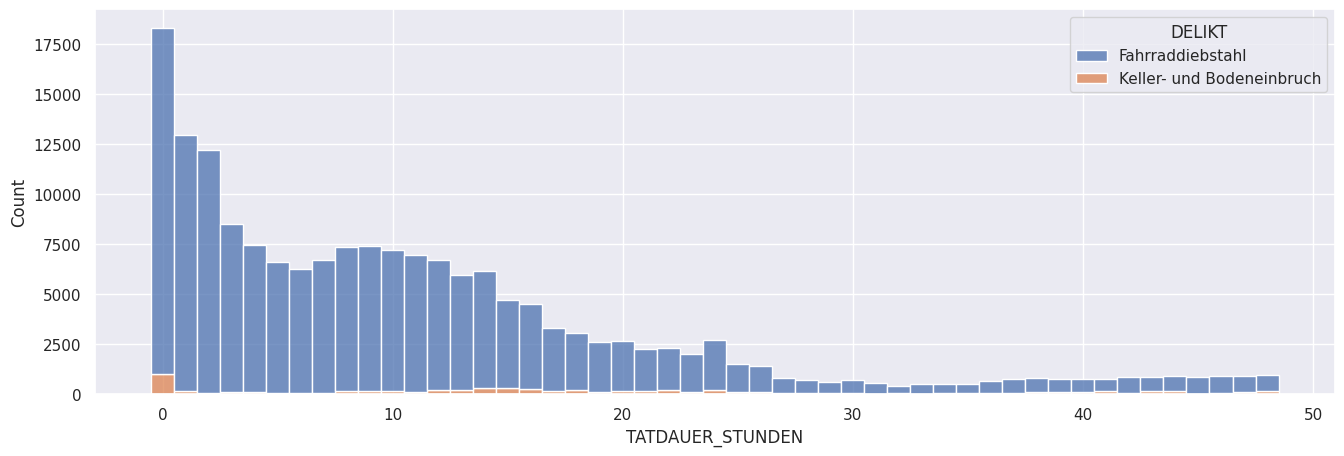

In [15]:
sns.histplot(
    data=merged_df,
    x="TATDAUER_STUNDEN",
    binrange=[0, 48],
    discrete=True,
    hue="DELIKT",
    multiple="stack",
)


### Wann finden Diebstähle im Allgemeinen statt?
- Die häufigsten Diebstähle finden statt zwischen
    - 7-9 Uhr morgens
    - 17-19 Uhr abends
- Die häufigsten Einbrüche finden statt zwischen
    - 11-13 Uhr mittags
    - 17-19 Uhr abends

<Axes: xlabel='TATZEIT_ANFANG_STUNDE', ylabel='Count'>

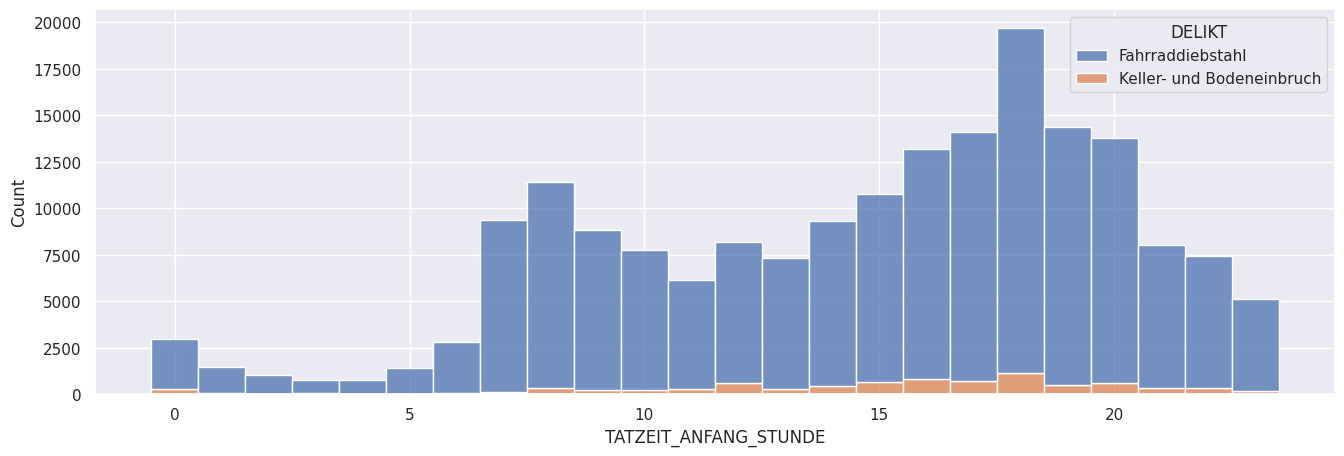

In [35]:
sns.histplot(
    data=merged_df,
    x="TATZEIT_ANFANG_STUNDE",
    discrete=True,
    hue="DELIKT",
    multiple="stack",
)

### Gibt es zeitliche Unterschiede zwischen den Bezirksregionen
- Diebstähle: scheinbar nicht, die Zeiten scheinen Bezirksregionen-unabhängig
- Einbrüche: scheinbar Bezirksabhängige Zeiten, aufgrund der geringen Absolutwerte jedoch mutmaßlich nicht signifikant

In [ ]:
# Achtung violinplot breite nicht nach count spezifiert. Breite ist willkürlich, es gibt deutlich mehr Fahrraddiebstähle als einbrüche.
n_oteil = 5
top_oteil_crime_lst = (
    merged_df.groupby("BZR_NAME")
    .agg({"ANGELEGT_AM": "count"})
    .sort_values(by=("ANGELEGT_AM"), ascending=False)
    .head(n_oteil)
    .index.to_list()
) + (
    merged_df.groupby("BZR_NAME")
    .agg({"ANGELEGT_AM": "count"})
    .sort_values(by=("ANGELEGT_AM"), ascending=True)
    .head(n_oteil)
    .index.to_list()
)

with sns.plotting_context("notebook", font_scale=1):

    plot_df = merged_df[merged_df.BZR_NAME.isin(top_oteil_crime_lst)]
    fig, axes = plt.subplots()
    sns.violinplot(
        x=plot_df.BZR_NAME,
        y=plot_df.TATZEIT_ANFANG_STUNDE,
        ax=axes,
        order=top_oteil_crime_lst,
        cut=0,
        hue=plot_df.DELIKT,
        split=True,
    )
    # sns.stripplot(
    #     data=plot_df,
    #     x=plot_df.BZR_NAME,
    #     y=plot_df.TATZEIT_ANFANG_STUNDE,
    #     size=3,
    #     color="black",
    #     alpha=0.2,
    # )

    axes.yaxis.grid(True)
    axes.set_xlabel("Bezirksregion")
    axes.set_ylabel("Tageszeit [Stunde]")
    plt.setp(axes.get_xticklabels(), rotation=30, ha="right")

    sns.move_legend(
        axes,
        "lower center",
        bbox_to_anchor=(0.5, 1),
        ncol=2,
        title=None,
        frameon=False,
    )


### Gibt es Unterschiede in den Schadenshöhen zwischen den Bezirksregionen
- Diebstähle: scheinbar nicht, die Zeiten scheinen Bezirksregionen-unabhängig
- Einbrüche: scheinbar Bezirksabhängige Zeiten, aufgrund der geringen Absolutwerte jedoch mutmaßlich nicht signifikant

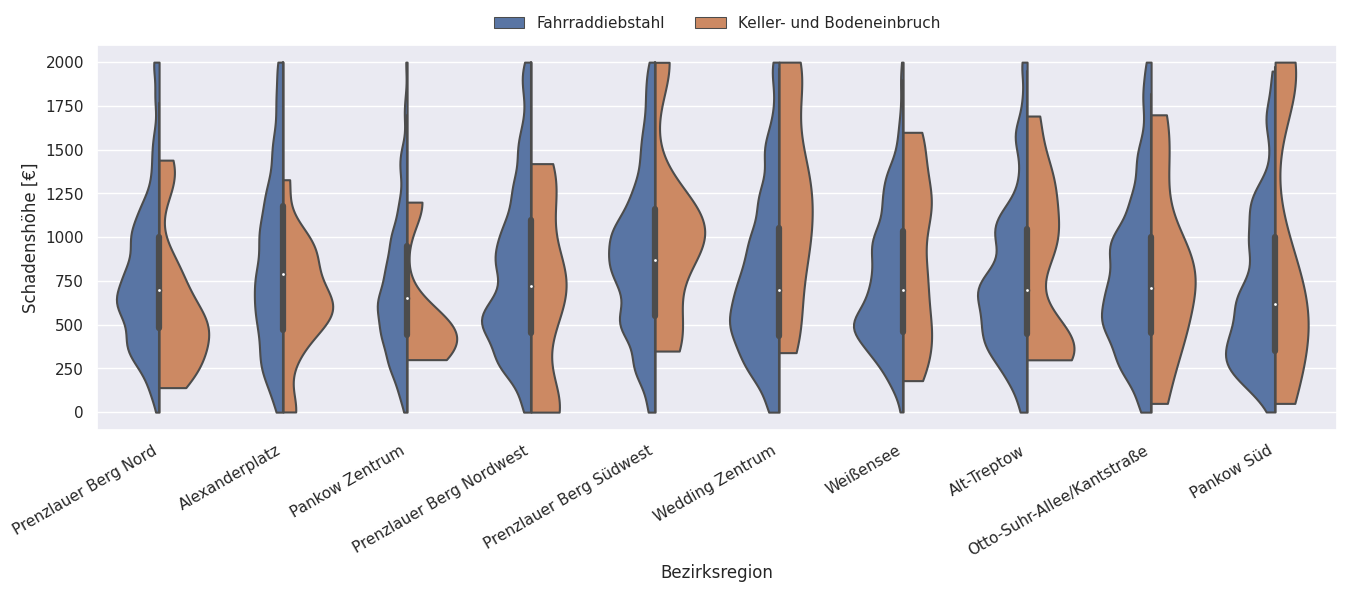

In [27]:
with sns.plotting_context("notebook", font_scale=1):
    
    plot_df = merged_df[(merged_df.BZR_NAME.isin(top_oteil_crime_lst)) & (merged_df.SCHADENSHOEHE <= 2000)]
    fig, axes = plt.subplots()
    sns.violinplot(
        x=plot_df.BZR_NAME,
        y=plot_df.SCHADENSHOEHE,
        data_set=plot_df,
        ax=axes,
        order=top_oteil_crime_lst,
        cut=0,
        hue=plot_df.DELIKT,
        split=True,
    )
    # sns.stripplot(
    #     data=plot_df,
    #     x=plot_df.BZR_NAME,
    #     y=plot_df.SCHADENSHOEHE,
    #     size=3,
    #     color="black",
    #     alpha=0.2,
    # )

    axes.yaxis.grid(True)
    axes.set_xlabel("Bezirksregion")
    axes.set_ylabel("Schadenshöhe [€]")
    plt.setp(axes.get_xticklabels(), rotation=30, ha="right")

    sns.move_legend(
        axes,
        "lower center",
        bbox_to_anchor=(0.5, 1),
        ncol=2,
        title=None,
        frameon=False,
    )


In [29]:
merged_df.groupby(["ART_DES_FAHRRADS"]).agg(
    {"ANGELEGT_AM": "count", "SCHADENSHOEHE": ["sum", "max"]}
).sort_values(by=("ANGELEGT_AM", "count"), ascending=False).head(10)


ANGELEGT_AM SCHADENSHOEHE       
                        count           sum    max
ART_DES_FAHRRADS                                  
Herrenfahrrad           86302      93611011   9900
Damenfahrrad            52438      47244094  10000
Fahrrad                 24051      30343950   9799
Mountainbike             7921       6599530   8000
Kinderfahrrad            7369       2999559   1950
diverse Fahrräder        5061      10016606  10000
Rennrad                  2550       3066361   8500
Lastenfahrrad             464       1141758   9000

/tmp/ipykernel_22885/3007216981.py:2: UserWarning: The palette list has more values (20) than needed (12), which may not be intended.
  sns.histplot(


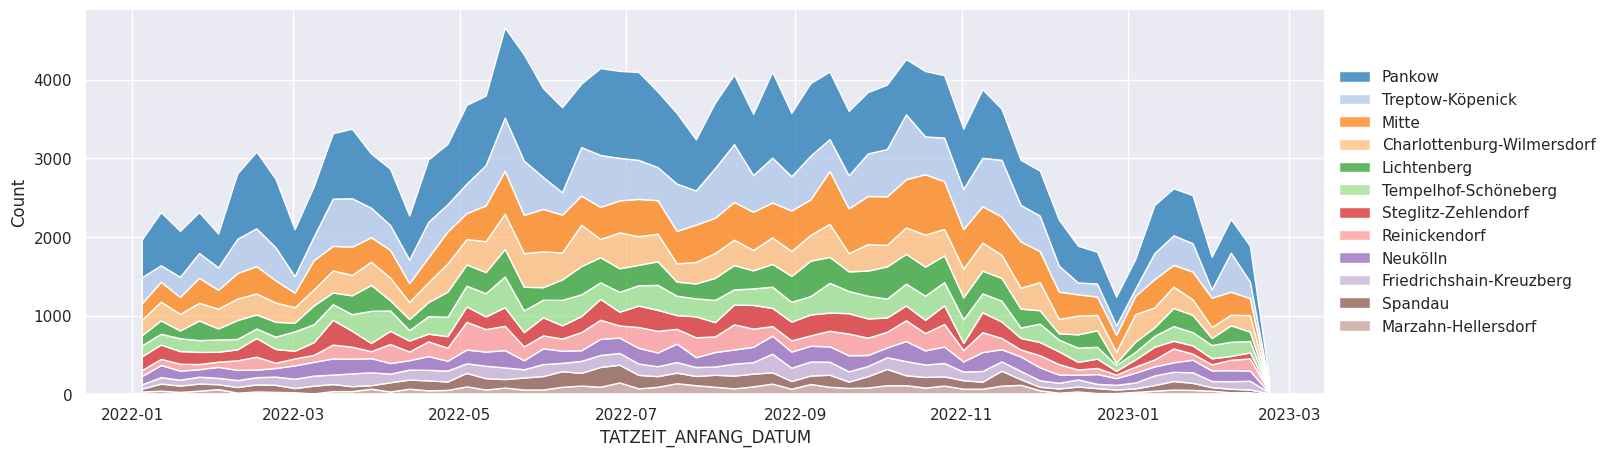

In [30]:
fig, ax = plt.subplots()
sns.histplot(
    ax=ax,
    data=merged_df,
    x="TATZEIT_ANFANG_DATUM",
    element="poly",
    hue="BEZIRK",
    hue_order=merged_df.groupby("BEZIRK")
    .agg({"LOR": "count"})
    .sort_values(by="LOR", ascending=False)
    .index.to_list(),
    multiple="stack",
    binwidth=7,
    palette=sns.color_palette("tab20"),
)
sns.move_legend(
    ax,
    "center left",
    bbox_to_anchor=(1, 0.5),
    title=None,
    frameon=False,
)

plt.show()


,SCHADENSHOEHE
VERSUCH,
Ja,0
Nein,194970189
Unbekannt,52680
